In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
    
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

### next is how we extracted raw chrom-wise interaction matrices from pairs.stats ..

In [ ]:
%%bash

cd /nl/umw_job_dekker/users/ba69w/HiC_Analysis/U54_matrix/results/pairs_library
for f in  *hg38.dedup.stats; do
    sample=$(echo $f | cut -f1 -d  "_");
    tot=$(grep "total_nodups" $f | cut -f2);
    tottot=$(grep "total\s" $f | cut -f2);
    grep "chrom_freq\/" $f > ~/ccc/${sample}__shallow__${tot}__${tottot}.tsv
done

cd /nl/umw_job_dekker/users/ba69w/HiC_Analysis/U54_deep/results/pairs_library
for f in  *hg38.dedup.stats; do
    sample=$(echo $f | cut -f1 -d  "_");
    tot=$(grep "total_nodups" $f | cut -f2);
    tottot=$(grep "total\s" $f | cut -f2);
    grep "chrom_freq\/" $f > ~/ccc/${sample}__deep__${tot}__${tottot}.tsv
done

In [84]:
# i had to install this beauty https://github.com/matplotlib/ipympl
# to make following to work ...

# %matplotlib widget
# import ipywidgets as widgets

%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import seaborn as sns

import numpy as np

from io import StringIO


# # make pandas display entire dataframes
# pd.set_option("display.max_rows", None, "display.max_columns", None)

def symmetrize(a):
    """
    Return a symmetrized version of NumPy array a.
    a may containt some NaNs on either side of the diagonal.

    Values 0 are replaced by the array value at the symmetric
    position (with respect to the diagonal), i.e. if a_ij = 0,
    then the returned array a' is such that a'_ij = a_ji.

    Diagonal values are left untouched.

    a -- square NumPy array, such that a_ij = 0 or a_ji = 0, 
    for i != j.
    """
    # find true NaN ij elements:
    nanmask = (np.isnan(a)+np.isnan(a.T)).astype(int)>1
    # tmp version of the matrix with NaN replaced to 0:
    _a = np.nan_to_num(a)
    # symmetrize _a:
    sa = _a + _a.T - np.diag(_a.diagonal())
    # place true NaNs back in:
    sa[nanmask] = np.nan
    return sa

In [121]:
!ssh ghpcc cat /home/sv49w/hg38.chroms

>chr1  AC:CM000663.2  gi:568336023  LN:248956422  rl:Chromosome  M5:6aef897c3d6ff0c78aff06ac189178dd  AS:GRCh38
>chr2  AC:CM000664.2  gi:568336022  LN:242193529  rl:Chromosome  M5:f98db672eb0993dcfdabafe2a882905c  AS:GRCh38
>chr3  AC:CM000665.2  gi:568336021  LN:198295559  rl:Chromosome  M5:76635a41ea913a405ded820447d067b0  AS:GRCh38
>chr4  AC:CM000666.2  gi:568336020  LN:190214555  rl:Chromosome  M5:3210fecf1eb92d5489da4346b3fddc6e  AS:GRCh38
>chr5  AC:CM000667.2  gi:568336019  LN:181538259  rl:Chromosome  M5:a811b3dc9fe66af729dc0dddf7fa4f13  AS:GRCh38  hm:47309185-49591369
>chr6  AC:CM000668.2  gi:568336018  LN:170805979  rl:Chromosome  M5:5691468a67c7e7a7b5f2a3a683792c29  AS:GRCh38
>chr7  AC:CM000669.2  gi:568336017  LN:159345973  rl:Chromosome  M5:cc044cc2256a1141212660fb07b6171e  AS:GRCh38
>chr8  AC:CM000670.2  gi:568336016  LN:145138636  rl:Chromosome  M5:c67955b5f7815a9a1edfaa15893d3616  AS:GRCh38
>chr9  AC:CM000671.2  gi:568336015  LN:138394717  rl:Chromosome  M5:6c198acf68b5af

In [128]:
!ssh ghpcc cat /home/sv49w/hg38.chroms | cut -f1,7 -d" "

>chr1 LN:248956422
>chr2 LN:242193529
>chr3 LN:198295559
>chr4 LN:190214555
>chr5 LN:181538259
>chr6 LN:170805979
>chr7 LN:159345973
>chr8 LN:145138636
>chr9 LN:138394717
>chr10 LN:133797422
>chr11 LN:135086622
>chr12 LN:133275309
>chr13 LN:114364328
>chr14 LN:107043718
>chr15 LN:101991189
>chr16 LN:90338345
>chr17 LN:83257441
>chr18 LN:80373285
>chr19 LN:58617616
>chr20 LN:64444167
>chr21 LN:46709983
>chr22 LN:50818468
>chrX LN:156040895
>chrY LN:57227415
>chrM LN:16569
>chr1_KI270706v1_random LN:175055
>chr1_KI270707v1_random LN:32032
>chr1_KI270708v1_random LN:127682
>chr1_KI270709v1_random LN:66860
>chr1_KI270710v1_random LN:40176
>chr1_KI270711v1_random LN:42210
>chr1_KI270712v1_random LN:176043
>chr1_KI270713v1_random LN:40745
>chr1_KI270714v1_random LN:41717
>chr2_KI270715v1_random LN:161471
>chr2_KI270716v1_random LN:153799
>chr3_GL000221v1_random LN:155397
>chr4_GL000008v2_random LN:209709
>chr5_GL000208v1_random LN:92689
>chr9_KI270717v1_random LN:40062
>chr9_KI270718v1_rando

In [139]:
# reading data in from ghpcc ...

chroms_info = !ssh ghpcc cat /home/sv49w/hg38.chroms | cut -f1,7 -d" "
chroms_info = "\n".join(chroms_info)
chroms_df = pd.read_csv(StringIO(chroms_info),sep=" ",header=None,names=["chr","len"])
chroms_df["chr"] = chroms_df["chr"].str.lstrip(">")
chroms_df["len"] = chroms_df["len"].str.lstrip("LN:").astype(int)

chroms = chroms_df["chr"].tolist()
chroms_len = {c:l for c,l in chroms_df.itertuples(index=False)}

dat_files = !ssh ghpcc ls /home/sv49w/ccc/
data = {}
for daf in dat_files:
    dat = !ssh ghpcc cat /home/sv49w/ccc/{daf}
    data[daf] = "\n".join(dat)

In [238]:
chroms_df[chroms_df["chr"].isin(hg38_contigs)].sort_values("len")

,chr,len
150,chrUn_KI270394v1,970
156,chrUn_KI270392v1,971
88,chrUn_KI270423v1,981
158,chrUn_KI270385v1,990
113,chrUn_KI270539v1,993
...,...,...
45,chr14_GL000225v1_random,211173
55,chr17_KI270729v1_random,280839
91,chrUn_KI270442v1,392061
52,chr15_KI270727v1_random,448248


In [140]:
hg38_chroms = chroms[:25]
hg38_contigs = chroms[25:]

In [141]:

def parse_u54_names(name_split):
    exptype = name_split[0]
    celltype = name_split[1]
    if (exptype == "ENCODE")and(celltype=="HeLa"):
        cross = "FA"
        enzyme = name_split[2]
        cycle = "NS"        
    elif (exptype == "U54")and(celltype == "HFFc6"):
        if name_split[2] in ["p17","p22"]:
            cross = name_split[3]
            enzyme = name_split[4]
        else:
            cross = name_split[2]
            enzyme = name_split[3]
        cycle = "NS"
    elif (exptype == "U54")and(celltype in ["END4DN", "H1ESC4DN", "HFFc64DN","HFFc6"]):
        cross = name_split[3]
        enzyme = name_split[4]
        cycle = "NS"        
    elif celltype in ["END","ESC","END4DN","ESC4DN","H1ESC4DN","ENDMaehr","hEND4DN"]:
        cross = name_split[2]
        enzyme = name_split[3]
        cycle = "NS"
    elif celltype in "HFF":
        cross = name_split[3]
        enzyme = name_split[4]
        cycle = "NS"
    elif celltype == "HelaS3":
        cross = name_split[3]
        enzyme = name_split[4]
        cycle = name_split[2]
    else:
        print("I'm something else - dela with me...")
        print(name_split)
        ret = {}
    if enzyme == "HindIIII":
        enzyme = "HindIII"
    if enzyme not in ['DdeI','DpnII','HindIII','MNase']:
        print("enzyme",enzyme,name_split)
    if cross not in ['DSG','EGS','FA']:
        print("cross",cross,name_split)
    if cycle not in ['NS','G1','M']:
        print("cycle",cycle,name_split)
    ret = {"cell":celltype, "cycle": cycle, "cross": cross, "enzyme": enzyme}
    return pd.Series(ret)

# # this should be the same for all of them, but it's ugly this way ...
# cell_cycle_cross_enzyme = parse_data("chrM")["name"].str.split("-").apply(parse_u54_names)

In [339]:
big_dat  =[]
names = []
for bebe in  dat_files:
    parse_u54_names(bebe.split("__")[0].split("-"))
    names.append("_".join(parse_u54_names(bebe.split("__")[0].split("-")).values))
    
    tot = int(bebe.split("__")[2])
    
    dtt = data[bebe]

    df = pd.read_csv(StringIO(dtt),sep="\t",header=None,names=["chrms","count"])
    df = df[["count"]].merge(
            df["chrms"].str.split("/",expand=True)[[1,2]].rename(columns={1:"chr1",2:"chr2"}),
            left_index=True,
            right_index=True
        )[["chr1","chr2","count"]]

    mat = df.pivot(index="chr1",columns="chr2",values="count") \
        .reindex(index=hg38_chroms,columns=hg38_chroms).values
    # coolect chrM interaction profiles ...
    big_dat.append( symmetrize(mat)[20]/tot )

### pre clustering excercise ...

sort of extract an interaction profile of a given chromosome for each sample and see how would it cluster:

In [267]:
dendrogram?

In [288]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import normalize

In [270]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [305]:
pdist?

In [340]:
X = normalize(np.vstack(big_dat),axis=0)
Z = linkage(X,method='ward',)

In [341]:
c, coph_dists = cophenet(Z, pdist(X))
c

0.6341181752253295

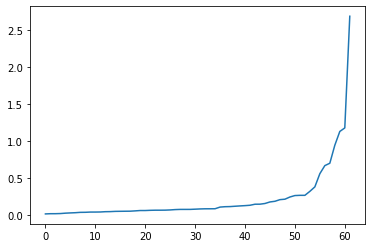

In [342]:
# distance between merged instances (samples or cluster heads) with iterations ...
plt.plot(Z[:,2])

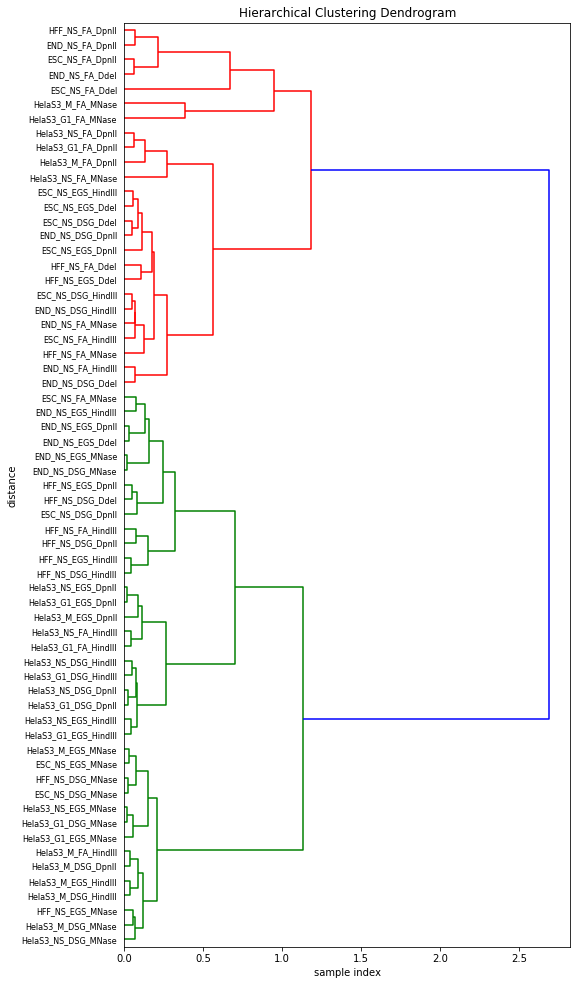

In [349]:
# calculate full dendrogram
plt.figure(figsize=(8, 17))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
rrr = dendrogram(
    Z,
    orientation="right",
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    leaf_label_func = lambda idx : names[idx]
)
plt.show()

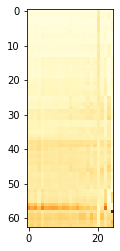

In [344]:
plt.imshow((X[rrr["leaves"]]),cmap="YlOrBr")

In [192]:
# mat = df.pivot(index="chr1",columns="chr2",values="count") \
#     .reindex(index=hg38_chroms,columns=hg38_chroms).values

In [193]:
_v = np.asarray([chroms_len[c] for c in hg38_chroms])
areas = np.outer(_v,_v)

In [194]:
np.fill_diagonal(mat,np.nanmean(mat))

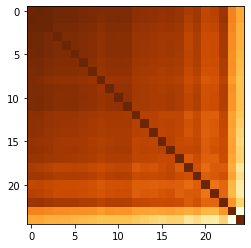

In [195]:
plt.imshow(np.log(symmetrize(mat)),cmap="YlOrBr")